# Data Visualization
What is still needed:
* EER, NER, WER data
* 

In [5]:
import os
import io
import zipfile
import requests

import numpy as np
import scipy as sp
import pandas as pd

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_columns', 500)
plt.rcParams['figure.figsize'] = 15, 6

In [6]:
def makeCorrPlots(x, y, df, log=False):
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    try:
        tmp = df[[x,y]]
        tmp = tmp.dropna()
        X, Y = tmp[x].astype(float), tmp[y].astype(float)
    except:
        print(x, y)
        return
    
    if not len(X) or not len(Y):
        return
    
    if log:
        X[X == 0] = 1e-12;
        X = np.log10(X)
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(X, Y)
    
    # plot2
    plt.scatter(X, Y, color='b', alpha=0.5)
    plt.plot(X, intercept + slope*X, color='firebrick')
    plt.title('{} v. {}{} (corr= {:.2f})'.format(y, 'log ' if log else '', x, np.corrcoef(X, Y)[0][1]))
    
def clean(df, col='eui', use_log=True, nonneg=False, nstd=2, onesided=None):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    onesided = nonneg if onesided is None else onesided
    try:
        if nonneg:
            df = df[df[col] >= 0]
        if use_log:
            df = df[df[col] != 0]
            vals = np.log10(df[col].astype(float))
        else:
            vals = df[col].astype(float)
    except ValueError:
        return df
    
    if nstd:
        vals_centered = vals - np.mean(vals)
        if not onesided:
            vals_centered = np.abs(vals_centered)
        return df[ vals_centered < nstd*np.std(vals) ]
    return df

In [11]:
borough_map = {
    'MN': 'Manhattan',
    'BK': 'Brooklyn',
    'BX': 'Bronx',
    'QN': 'Queens',
    'SI': 'Staten Island'
}

## The Data

In [27]:
df = pd.read_csv('final_df.csv')

# Make borough names pretty
df.Borough = df.Borough.map(borough_map)

df.head()

,Unnamed: 0,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,TYPE_2016,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address,Latitude,Longitude,age,avgEUI,km_group,Group_mean_EUI_2016,Group_median_EUI_2016,Group_min_EUI_2016,Group_max_EUI_2016,Group_std_EUI_2016,Group_size_EUI_2016,EER_km,Pred_EUI_lr,EER_lr,avgEER
0,0,1011200022,62.4,64899.0,54.2,64899.0,65.4,64899.0,22.4,64899.0,Multifamily Housing,Manhattan,7532.0,64899.0,0.0,64899.0,0.0,0.0,14.0,31.0,31.0,1905.0,990009.0,221143.0,10023.0,15 WEST 67 STREET,40.773661,-73.979207,112.0,60.666667,1,212.52613,85.7,0.1,116258.9,2818.991617,6636.0,0.105399,226.975644,0.098689,0.101934
1,1,1000157502,50.1,227463.0,36.6,259076.0,78.0,259076.0,42.7,259076.0,Multifamily Housing,Manhattan,13928.0,179856.0,10000.0,168748.0,0.0,10000.0,45.0,283.0,284.0,1930.0,979922.0,196558.0,10004.0,20 WEST STREET,40.706182,-74.015610,87.0,54.900000,1,212.52613,85.7,0.1,116258.9,2818.991617,6636.0,0.200916,396.260332,0.107757,0.140279
2,2,1000157502,50.1,227463.0,36.6,259076.0,78.0,259076.0,42.7,259076.0,Multifamily Housing,Manhattan,13928.0,179856.0,10000.0,168748.0,0.0,10000.0,45.0,283.0,284.0,1930.0,979922.0,196558.0,10004.0,20 WEST STREET,40.706182,-74.015610,87.0,54.900000,1,212.52613,85.7,0.1,116258.9,2818.991617,6636.0,0.200916,396.260332,0.107757,0.140279
3,3,1000157502,50.1,227463.0,36.6,259076.0,78.0,259076.0,42.7,259076.0,Multifamily Housing,Manhattan,13928.0,179856.0,10000.0,168748.0,0.0,10000.0,45.0,283.0,284.0,1930.0,979922.0,196558.0,10004.0,20 WEST STREET,40.706182,-74.015610,87.0,54.900000,1,212.52613,85.7,0.1,116258.9,2818.991617,6636.0,0.200916,396.260332,0.107757,0.140279
4,4,1000157502,50.1,227463.0,36.6,259076.0,78.0,259076.0,42.7,259076.0,Multifamily Housing,Manhattan,13928.0,179856.0,10000.0,168748.0,0.0,10000.0,45.0,283.0,284.0,1930.0,979922.0,196558.0,10004.0,20 WEST STREET,40.706182,-74.015610,87.0,54.900000,1,212.52613,85.7,0.1,116258.9,2818.991617,6636.0,0.200916,396.260332,0.107757,0.140279


In [28]:
PLUTO_cache = 'data/pluto16.csv'
PLUTO_url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip'

if not os.path.isfile(PLUTO_cache):
    # Make sure directory exists
    if not os.path.isdir('data'):
        os.makedirs('data')
    
    with zipfile.ZipFile(io.BytesIO(requests.get(PLUTO_url).content)) as z:
        # Join all csv files in the archive
        df_pluto = pd.concat([
            pd.read_csv(z.open(f))
            for f in z.namelist()
            if os.path.splitext(f)[1] == '.csv'
        ])
    
    # Save cache
    df_pluto.to_csv(PLUTO_cache, index=False)

df_pluto = pd.read_csv(PLUTO_cache)


df_pluto.Borough = df_pluto.Borough.map(borough_map)

df_pluto.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,Brooklyn,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JOHN STREET,M3-1,M1-4/R8A,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,V1,11.0,1,P,BROOKLYN BRIDGE PARK,151930,0,0,0,0,0,0,0,0,0,4,0,0.0,0,0,206.25,337.42,0.0,0.0,NaN,0.0,Y,5.0,5.0,1164645.0,1164645.0,0.0,0.0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3.000010e+09,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,Brooklyn,1,50,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,10 JAY STREET,M1-4/R8A,M3-1,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,NaN,Y,E9,6.0,0,NaN,SAFDI PLAZA REALTY IN,19682,154400,154400,0,17160,0,0,68620,0,68620,2,1,9.0,0,90,109.08,207.25,88.0,195.0,NaN,1.0,Y,3.0,0.0,834300.0,12019950.0,0.0,290250.0,1920,1994,2007,DUMBO Historic District,NaN,7.84,5.4,2.0,6.5,3,3.000010e+09,0,21,987838.0,195989.0,12d,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2
2,Brooklyn,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,1.0,2.0,NaN,1 JOHN STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RM,4.0,1,NaN,NaN,0,102534,4686,97848,0,4686,0,0,0,0,7,1,12.0,42,44,0.00,0.00,0.0,0.0,NaN,0.0,N,0.0,5.0,389696.0,5864853.0,0.0,0.0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3.000018e+09,3819,21,987624.0,195992.0,12d,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2
3,Brooklyn,3,1,302,21.0,3002.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,U4,7.0,1,NaN,CONSOLIDED EDISON CO/,387060,0,0,0,0,0,0,0,0,0,7,15,0.0,0,0,1051.00,469.00,0.0,0.0,NaN,0.0,Y,5.0,5.0,0.0,0.0,0.0,0.0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3.000030e+09,0,21,988568.0,196151.0,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,Brooklyn,3,5,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,T2,7.0,0,C,NYC DSBS,6384,0,0,0,0,0,0,0,0,0,7,0,0.0,0,0,0.00,0.00,0.0,0.0,NaN,0.0,N,5.0,5.0,21150.0,21150.0,21150.0,21150.0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3.000030e+09,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2


## Distribution of our Output Variables

KeyError: 'water_intensity'

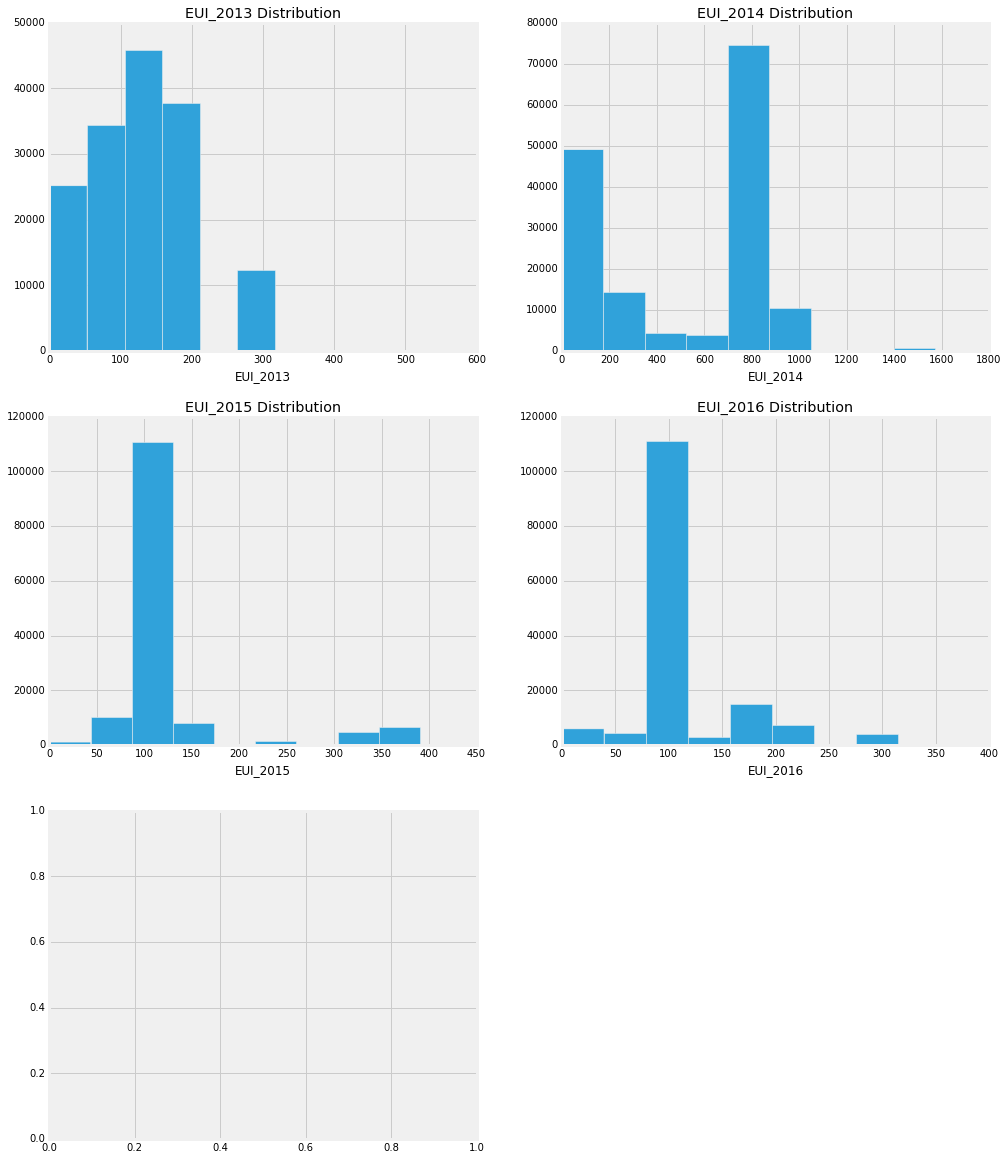

In [29]:
plt.figure(figsize=(15, 20))

columns = ['EUI_2013', 'EUI_2014', 'EUI_2015', 'EUI_2016', 'water_intensity', 'naturalgas_intensity']
names = columns # give prettier names [..., 'Natural Gas Intensity (kBtu/ft^2)]

for i, (name, col) in enumerate(zip(names, columns), 1):
    plt.subplot(3,2,i)
    plt.hist(clean(df, col, nonneg=True)[col]) # Clean gets rid of outliers
    plt.title('{} Distribution'.format(name))
    plt.xlabel(name) # should add units

## Total Number of Buildings in each borough

In [ ]:
plt.figure(figsize=(15, 6))

# Get counts
prop = df.groupby('Borough').count()['ZipCode'].sort_values()
xprop = np.arange(len(prop))

plt.barh(xprop, prop.values * 100.)
plt.title('Total In-Scope Buildings by Borough')
plt.xlabel('Number of Total Buildings Reporting')
plt.yticks(xprop + 0.4, prop.index);

## Percent of Total Buildings for each borough represented in this dataset
Same as above but divided by the total number of buildings in PLUTO for that borough.

In [ ]:
# Get percentages
prop = (df.groupby('Borough').count()['ZipCode'] / df_pluto.groupby('Borough').count()['ZipCode']).sort_values()
xprop = np.arange(len(prop))

plt.barh(xprop, prop.values * 100.)
plt.title('Percent In-Scope Buildings by Borough')
plt.xlabel('Percent of Total Buildings Reporting (%)')
plt.yticks(xprop + 0.4, prop.index);

## Relationship between EER, NER, and WER
EER, NER, WER two at a time to see if the pattern moves together

In [ ]:
for i, (x, y) in enumerate([('EER', 'NER'), ('EER', 'WER'), ('WER', 'NER')], 1):
    plt.subplot(1, 3, i)
    makeCorrPlots(x, y, df, log=True)
    plt.xlabel(x)
    plt.ylabel(y)

## Log histogram of each EER, NER, WER for multifamily

In [ ]:
for i, col in enumerate(['EER', 'NER', 'WER'], 1):
    plt.subplot(1, 3, i)
    plt.hist(col)

## Plot EUI of individual clusters?
Not sure if we need this or if it'd be interesting

In [ ]:
n_groups = len(df['km_group'].unique())
for i, group in enumerate(df.groupby('km_group'), 1):
    plt.subplot(n_groups/2, 2, i)
    group.hist('EUI_2016')

## Clustering Silhouette Scores

In [ ]:
# The features to use
features = [ ... ]
U = df[features]

# The range of clusters to try
x_sil = np.arange(2, 11)

# Compute silhouette scores
sil_scores = [
    silhouette_score(U, KMeans(i).fit(U).labels_)
    for i in x_sil
]

print('The best silhouette score is at: {} clusters'.format(x_sil[np.argmax(sil_scores)]))
plt.figure(figsize=(15,6))
plt.plot(x_sil, sil_scores)
plt.title('KMeans Evaluation: Silhouette Score')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score');

## Lasso Regularization Validation

In [ ]:
# Create 10 random training-validation splits
splits = [
    train_test_split(df[features], df['EUI_2016'], train_size=0.7)
    for _ in range(10)
]

# Pick lambdas for validation
lambdas = np.linspace(10, 1000, 100)

# Compute R^2 for each model and each split
split_scores = [
    [
        Lasso(alpha=lam).fit(X_tr, y_tr).score(X_val, y_val)
        for lam in lambdas
    ]
    for X_tr, X_val, y_tr, y_val in splits
]

# Plot scores for all splits
for i, models in enumerate(split_scores, 1):
    # Plot score for each model
    for label, scores in models.items():
        plt.plot(lambdas, scores, label='Split {}'.format(i))
plt.title('Cross Validation of Lasso Regression Regularization Value')
plt.xlabel('Lambda Value')
plt.ylabel('R Squared')
plt.legend()

## Anything else?